In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import floor
from scipy.stats.stats import pearsonr

In [27]:
project_folder = "."

In [28]:
# Read time series for McDonald's stock and drop non open/high/low/close/volume columns
mcd = pd.read_csv(f'{project_folder}/EOD-MCD.csv', index_col=0)
mcd.drop(['Adj_Open','Adj_High','Adj_Low','Adj_Close','Adj_Volume','Dividend','Split'], axis=1, inplace=True, errors="skip")
mcd.sort_index(inplace=True)
mcd.head()

,Open,High,Low,Close,Volume
Date,,,,,
1970-01-02,43.00,44.25,43.0,44.25,23256.0
1970-01-05,44.25,45.00,44.0,45.00,18193.0
1970-01-06,45.00,45.75,45.0,45.25,16059.0
1970-01-07,45.25,45.75,45.0,45.00,22459.0
1970-01-08,45.00,45.38,45.0,45.00,18456.0


In [29]:
import os, sys, inspect
sys.path.append(project_folder)
from pyESN import ESN

In [30]:
# Get Features and predicting variable, which is chosen to be Adj_Close since it determines the price of a stock at the end of a day
X = mcd.drop(['Close'], axis=1).values
Y = mcd['Close'].values

# Split data into 75/25 train/test
train_len = floor(X.shape[0]*0.75)
train_x = X[:train_len]
train_y = Y[:train_len]
test_x = X[train_len:]
test_y = Y[train_len:]

assert(train_x.shape[0] + test_x.shape[0] == X.shape[0])

# Reshape Y so that ESN work
train_y = np.reshape(train_y,newshape=(train_y.shape[0],1))
test_y = np.reshape(test_y,newshape=(test_y.shape[0],1))

In [31]:
def nrmse(y, yhat):
    """
        Function to output Normalized Mean Square Error of two numpy arrays
    """
    y = np.reshape(y, -1)
    yhat = np.reshape(yhat, -1)
    error = np.sqrt(np.mean((y-yhat)**2))/(np.max(y) - np.min(y))
    return error

## Task 1: Impact of input and RNN weight scalings on performance of ESN

In order to solve Task 1, i.e. check how performance is affected by scaling input weights $W_{ax}$ and RNN weights $W_{aa}$, we need to generate various scalings for each of four inputs and run train/test for this specific model.

In [32]:
def cartprod(*arrays):
    N = len(arrays)
    return np.transpose(np.meshgrid(*arrays, indexing='ij'), np.roll(np.arange(N + 1), -1)).reshape(-1, N)

In [33]:
# Generate scalings for each of four inputs
scalings = []
for i in range(4):
    scalings.append(np.arange(0.5, 5, step = 0.5))

input_scalings = cartprod(*scalings)
input_scalings.shape

(6561, 4)

In [ ]:
# For each combination of input scalings run training and testing on McDonald's stock data and record the results.
input_scaling_nrmse = []
input_scaling_labels = []
for i in range(input_scalings.shape[0]):
    esn = ESN(n_inputs = 4,
          n_outputs = 1,
          spectral_radius = 0.25,
          sparsity = 0.95,
          input_scaling = input_scalings[i])
    
    esn.fit(train_x, train_y)
    predictions = esn.predict(test_x)
    error = nrmse(test_y, predictions)
    label = f"{input_scalings[i][0]}-{input_scalings[i][1]}-{input_scalings[i][2]}-{input_scalings[i][3]}"
    print(f"Iteration: {i}, label: {label}, NRMSE: {error}")
    input_scaling_nrmse.append(error)
    input_scaling_labels.append(label)
    
    if i%100 == 0:
        df = pd.DataFrame({'label': input_scaling_labels, 'nrmse': input_scaling_nrmse})
        df.to_csv(f'{project_folder}/input_scaling_results.csv',index=False)

df = pd.DataFrame({'label': input_scaling_labels, 'nrmse': input_scaling_nrmse})
df.to_csv(f'{project_folder}/input_scaling_results.csv',index=False)

After running the training and testing for each input scaling, we can compare it with performance of ESN without providing input scalings and plot how error rate is changing for specific scaling. The result is saved in 'input_sacling_results.csv' file, which contains 2 columns: 'label' and 'nrmse', where label is 4 numbers that are used in scaling 4 inputs, separated by dash.

In [34]:
scalings_results = pd.read_csv(f'{project_folder}/input_scaling_results.csv')
scalings_results.head()

,label,nrmse
0,0.5-0.5-0.5-0.5,0.002889
1,0.5-0.5-0.5-1.0,0.002888
2,0.5-0.5-0.5-1.5,0.002895
3,0.5-0.5-0.5-2.0,0.002893
4,0.5-0.5-0.5-2.5,0.002891


In [35]:
# Let's train/test ESN without providing any input scaling so that we can compare with the rest.
esn = ESN(n_inputs = 4,
          n_outputs = 1,
          spectral_radius = 0.25,
          sparsity = 0.95)
esn.fit(train_x, train_y)
predictions = esn.predict(test_x)
no_scaling_error = nrmse(test_y, predictions)
print(f"No scaling NRMSE is: {no_scaling_error}")

No scaling NRMSE is: 0.002891794927350494


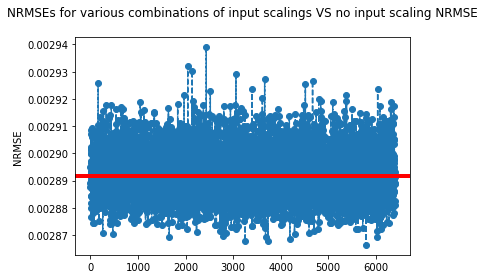

In [36]:
scaling_nrmses = scalings_results['nrmse'].values
scaling_labels = scalings_results['label'].values

fig, ax = plt.subplots()
ax.plot(scaling_nrmses, 'o--')
ax.set_title("NRMSEs for various combinations of input scalings VS no input scaling NRMSE\n")
ax.set_ylabel("NRMSE")
ax.axhline(no_scaling_error, linewidth=4, color='r')
plt.show()

Above given plot shows the NRMSE for various input scalings, while red line shows the error of ESN without scaling any input. Since the graph is not showing very well how error was improved due to big amount of points, we should plot only those errors that are below the red line.

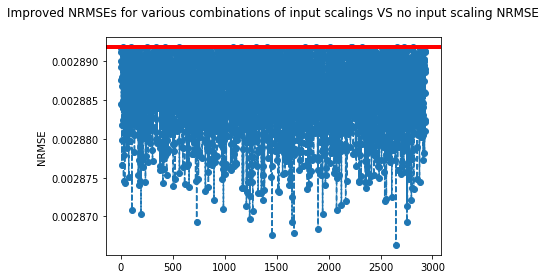

No scaling error is: 0.002891794927350494 and lowest with scaling error is: 0.002866340332593146

The error is improved by: 0.8880520735065511%

The best scaling for 4 inputs is: 4.0-4.5-3.0-0.5



In [37]:
better_errors = scaling_nrmses[np.where(scaling_nrmses < no_scaling_error)[0]]

fig, ax = plt.subplots()
ax.plot(better_errors, 'o--')
ax.set_title("Improved NRMSEs for various combinations of input scalings VS no input scaling NRMSE\n")
ax.set_ylabel("NRMSE")
ax.axhline(no_scaling_error, linewidth=4, color='r')
plt.show()
percentage_improvement = 100*(no_scaling_error/np.min(scaling_nrmses) - 1)
best_scaling = scaling_labels[np.argmin(scaling_nrmses)]

print(f"No scaling error is: {no_scaling_error} and lowest with scaling error is: {np.min(scaling_nrmses)}\n")
print(f"The error is improved by: {percentage_improvement}%\n")
print(f"The best scaling for 4 inputs is: {best_scaling}\n")

As we can see the input scalings indeed improve the test error, aka performance compared to no scaling of inputs. However the improvement in error rate is just 0.32%, which is not a lot. The error itself is quite low, so improving farther is obviously hard.

### Trying to detect extreme values for input scaling
Values of the input scaling that cause the error to increase as the system acts in a non-linear regime (large scaling) or very basic linear regime (small scaling).

In [38]:
import copy
# Generate scalings for each of four inputs
scalings = []
for i in range(4):
    scalings.append(np.arange(2, 100000, step = 50000))

scalings = []
for i in range(4):
    if i<2:
        #scalings.append(np.arange(2, 100000000, step = 40000000))
        #scalings.append(np.array([2] + [2**i for i in (1,4,26) ]))
        scalings.append(np.array([400000000,800000000]))
    else:    
        scalings.append(np.arange(2,3, step=1))


input_scalings = cartprod(*scalings)
print(input_scalings.shape)
input_scalings = input_scalings[::-1]
print(input_scalings[:3,:3])

input_scalings = np.array([[40000002, 80000002, 80000002, 2]])
print(input_scalings[:3,:3])

(4, 4)
[[800000000 800000000         2]
 [800000000 400000000         2]
 [400000000 800000000         2]]
[[40000002 80000002 80000002]]


In [39]:
# For each combination of input scalings run training and testing on McDonald's stock data and record the results.
input_scaling_nrmse = []
input_scaling_labels = []
for i in range(input_scalings.shape[0]):
    esn = ESN(n_inputs = 4,
          n_outputs = 1,
          spectral_radius = 0.25,
          sparsity = 0.95,
          input_scaling = input_scalings[i])
    
    esn.fit(train_x, train_y)
    predictions = esn.predict(test_x)
    error = nrmse(test_y, predictions)
    label = f"{input_scalings[i][0]}-{input_scalings[i][1]}-{input_scalings[i][2]}-{input_scalings[i][3]}"
    print(f"Iteration: {i}, label: {label}, NRMSE: {error}")
    input_scaling_nrmse.append(error)
    input_scaling_labels.append(label)

df = pd.DataFrame({'label': input_scaling_labels, 'nrmse': input_scaling_nrmse})
df.to_csv(f'{project_folder}/input_scaling_results_extreme.csv',index=False)

Iteration: 0, label: 40000002-80000002-80000002-2, NRMSE: 0.003307190551772968


In [40]:
scalings_results = pd.read_csv(f'{project_folder}/input_scaling_results_extreme.csv')
scalings_results.head()
scalings_results.sort_values(by=['nrmse'], ascending=False)

,label,nrmse
0,40000002-80000002-80000002-2,0.003307


In [41]:
# Let's train/test ESN without providing any input scaling so that we can compare with the rest.
esn = ESN(n_inputs = 4,
          n_outputs = 1,
          spectral_radius = 0.25,
          sparsity = 0.95)
esn.fit(train_x, train_y)
predictions = esn.predict(test_x)
no_scaling_error = nrmse(test_y, predictions)
print(f"No scaling NRMSE is: {no_scaling_error}")

No scaling NRMSE is: 0.0028945356047457736


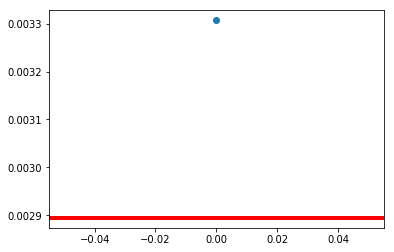

In [42]:
scaling_nrmses = scalings_results['nrmse'].values
scaling_labels = scalings_results['label'].values

fig, ax = plt.subplots()
ax.plot(scaling_nrmses, 'o--')
ax.axhline(no_scaling_error, linewidth=4, color='r')
plt.show()

In [ ]:
scalings_results = pd.read_csv(f'{project_folder}/input_scaling_results.csv')
scalings_results.head()
scalings_results.sort_values(by=['nrmse'], ascending=False)

## Task 2: Impact of Teacher Signal scaling and shifting on performance of ESN

Since we saw what was the impact on performance from scaling of inputs, we can proceed and check the impact on scaling and shifting of teacher signal. First we need to generate 2 arrays and perform cartesian product to form all possible combinations of scaling and shifting teacher signal parameters.

In [43]:
teach_scaling = np.round(np.arange(0.1, 5, step=0.1), 1)
teach_shift = np.round(np.arange(-5, 5, step=0.1), 1)

teacher_scalings = cartprod(teach_scaling, teach_shift)
teacher_scalings.shape

(4900, 2)

In [ ]:
# For each combination of teaching scalings run training and testing on McDonald's stock data and record the results.
teacher_scaling_nrmse = []
teacher_scaling_labels = []
for i in range(teacher_scalings.shape[0]):
    esn = ESN(n_inputs = 4,
          n_outputs = 1,
          spectral_radius = 0.25,
          sparsity = 0.95,
          teacher_scaling = teacher_scalings[i][0],
          teacher_shift = teacher_scalings[i][1])
    
    esn.fit(train_x, train_y)
    predictions = esn.predict(test_x)
    error = nrmse(test_y, predictions)
    label = f"{teacher_scalings[i][0]}_{teacher_scalings[i][1]}"
    print(f"Iteration: {i}, label: {label}, NRMSE: {error}")
    teacher_scaling_nrmse.append(error)
    teacher_scaling_labels.append(label)
    
    if i%100 == 0:
      df = pd.DataFrame({'label': teacher_scaling_labels, 'nrmse': teacher_scaling_nrmse})
      df.to_csv(f'{project_folder}/teacher_scaling_results.csv',index=False)

df = pd.DataFrame({'label': teacher_scaling_labels, 'nrmse': teacher_scaling_nrmse})
df.to_csv(f'{project_folder}/teacher_scaling_results.csv',index=False)

In [44]:
teacher_scaling_results = pd.read_csv(f'{project_folder}/teacher_scaling_results.csv')
teacher_scaling_results.head()

,label,nrmse
0,0.1_-5.0,0.002872
1,0.1_-4.9,0.002885
2,0.1_-4.8,0.002877
3,0.1_-4.7,0.002877
4,0.1_-4.6,0.002875


After running training and testing for all combinations of teacher scaling and shifting, we can proceed to understand how they affect the overall performance in terms of testing error.

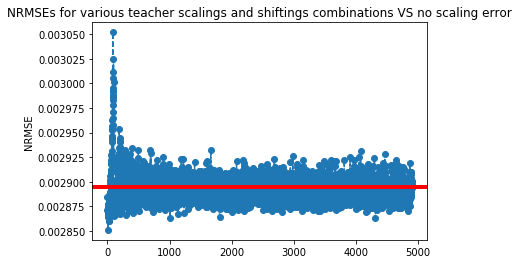

In [46]:
teacher_scaling_nrmses = teacher_scaling_results['nrmse'].values
teacher_scaling_labels = teacher_scaling_results['label'].values

fig, ax = plt.subplots()
ax.set_title("NRMSEs for various teacher scalings and shiftings combinations VS no scaling error")
ax.set_ylabel("NRMSE")
ax.plot(teacher_scaling_nrmses, 'o--')
ax.axhline(no_scaling_error, linewidth=4, color='r')
plt.show()

As with input scalings we see that some values are below the no scaling error, so we need to again plot a graph where values are only less than error without scaling.

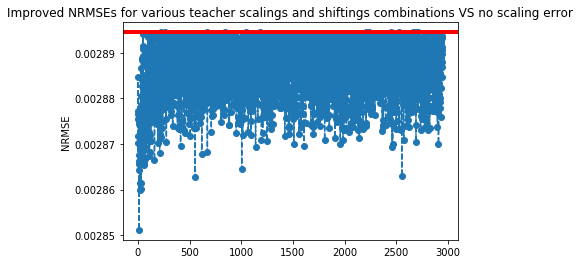

No scaling error is: 0.0028945356047457736 and lowest with scaling error is: 0.003307190551772968

The error is improved by: 1.5213051947950085%

The best scaling for teacher and shiftings are: 0.1_-4.0 respectively



In [48]:
teacher_better_errors = teacher_scaling_nrmses[np.where(teacher_scaling_nrmses < no_scaling_error)[0]]

fig, ax = plt.subplots()
ax.plot(teacher_better_errors, 'o--')
ax.set_title("Improved NRMSEs for various teacher scalings and shiftings combinations VS no scaling error")
ax.set_ylabel("NRMSE")
ax.axhline(no_scaling_error, linewidth=4, color='r')
plt.show()
percentage_improvement = 100*(no_scaling_error/np.min(teacher_better_errors) - 1)
best_scaling = teacher_scaling_labels[np.argmin(teacher_scaling_nrmses)]

print(f"No scaling error is: {no_scaling_error} and lowest with scaling error is: {np.min(scaling_nrmses)}\n")
print(f"The error is improved by: {percentage_improvement}%\n")
print(f"The best scaling for teacher and shiftings are: {best_scaling} respectively\n")

Again as with scaling of inputs, the error wasn't improved much. It is mainly due to the fact that the initial error without any scaling was already very small.

## Task 3: Memory capacity of ESN Network

#### Quantification of the memory capacity
We need to compute the following measure:
$C = \sum_{i=1,2,..} r^2(u(n-i),y_{i}(n))$

where $r^2(u(n−i),y_{i}(n))$ is the squared correlation coefficient between the input signal delayed by i and a trained output signal $y_i(n)$ which was trained on the task to retrodict (memorize) $u(n−i)$ on the input signal $u(n)$ . 

In [ ]:
from math import floor
c = np.zeros(train_x.shape[1])
capacities = np.zeros((len(range(1,floor(test_x.shape[0]/2))), train_x.shape[1]))

for i in range(1,floor(test_x.shape[0]/2)):
    esn = ESN(n_inputs = 1,
              n_outputs = 1,
              spectral_radius = 0.25,
              sparsity = 0.95,
              teacher_scaling = 0.1,
              teacher_shift = -4.0
             )
    
    train_y2 = np.zeros([i])
    train_y2 = np.hstack((train_y2,train_x[:-i,0]))
    
    # For each input (out of 4) train the ESN network and calculate the memory capacity
    # Expressed by above given formula
    for j in range(train_x.shape[1]):
      esn.fit(train_x[:,j], train_y2)
      predictions = esn.predict(test_x[:-i,j])
      ci = pearsonr(predictions[:,0],test_x[i:,j])
      ci = ci[0]**2
      
      c[j] = c[j] + ci
      capacities[i][j] = ci
      print(f"Delay: {i}-{j}. Capacity: {ci}")
    
    if i%100 == 0:
      print("Saving DF")
      df = pd.DataFrame(data=capacities, columns=['memory_cap_open','memory_cap_high','memory_cap_low','memory_cap_volume'])
      df.to_csv(f"{project_folder}/memory_capacities.csv", index=False)

df = pd.DataFrame(data=capacities, columns=['memory_cap_open','memory_cap_high','memory_cap_low','memory_cap_volume'])
df.to_csv(f"{project_folder}/memory_capacities.csv", index=False)

In [52]:
df_capacities = pd.read_csv(f"{project_folder}/memory_capacities.csv")
df_capacities = df_capacities[(df_capacities.T != 0).any()]
df_capacities.shape
c = [0 for _ in range(train_x.shape[1])]
with open(f"{project_folder}/total_capacities.txt") as f:
    c = f.readlines()[0]

After having all memory capacities up to 1500 delays, we can plot how they are changing for each of 4 inputs.

Total memory capacity for each input is: 0.5271293  0.02827466 0.52461713 0. 



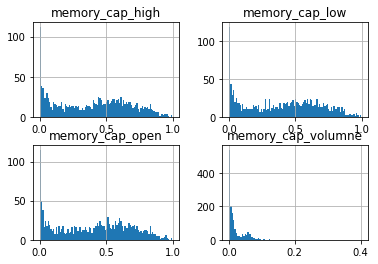

In [53]:
inputs = df_capacities.columns
caps = df_capacities.values
df_capacities.hist(bins=100)
print(f"Total memory capacity for each input is: {c}")

As we can see from above histrograms of memory capacities are mostly close to 0 in all inputs. However when it comes to memory capacities for each of 1500 states above 0, they are distributed equally same for 3 inputs. Except volume. The maximum memory capacity for volume seems to be slighty more than 0.1. Which can mean that volume should not be a good choice of input for LSTM algorithm.